<a href="https://colab.research.google.com/github/ThomasGoud/MasterClassSophia/blob/main/Final_AEIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Auto-Encoder feature extractor + Isolation Forest detector

## Library Importation

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

## Data Downloading

In this section we download the test / train data

In [ ]:
# Definition of load_data function
def load_data(name_file):
    data = pd.read_csv(name_file)
    data['time'] = pd.to_datetime(data['time']) #converting the time column to DateTime format
    data = data.set_index(['time']) #setting the DateTime Index
    return data

# Loading training data
train_data = load_data('train_data.csv')

# Loading test data + centering on anomaly
test_data = load_data('test_data.csv')
test_data = test_data.iloc[10000:17000]

## Label Creation

We define the label, '1' when an anomaly is detected

In [ ]:
labels = pd.DataFrame(index=test_data.index.tz_localize(None),data=np.zeros(test_data.size))
labels[((labels.index>pd.Timestamp('2021-06-10 10:20:00')) & (labels.index<pd.Timestamp('2021-06-10 10:39:00')))]=1
labels[((labels.index>pd.Timestamp('2021-06-10 11:46:00')) & (labels.index<pd.Timestamp('2021-06-10 12:01:00')))]=1

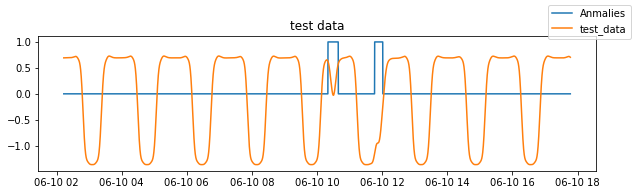

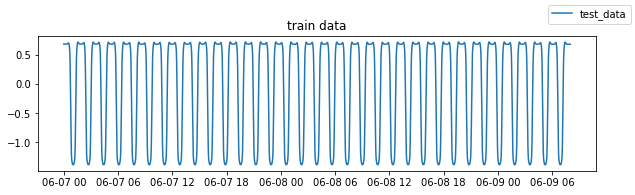

In [ ]:
# Display test data
%matplotlib inline
fig, axs = plt.subplots(figsize=(9,3))
fig.tight_layout(pad=3.0)            
axs.plot(labels, label="Anmalies")
axs.plot(test_data, label="test_data" )
axs.set_title('test data')
fig.legend()

# Display train data
fig, axs = plt.subplots(figsize=(9,3))
fig.tight_layout(pad=3.0)            
axs.plot(train_data, label="test_data" )
axs.set_title('train data')
fig.legend()

## Model parameter definition

In [ ]:
# Number of estimator for Isolation Forest
n_estimators = 400
# Auto Encoder Input/Output dimensions
window_size = 800
encoding_dim = 256

# Epoch for AE training
epochs = 12
# Number of window before weight update
batch_size = 32
# Dimension of input variable (1 value for 1 timestep )
nb_features_input = 1

## Model Creation

### Auto-encoder

In [ ]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model

In [ ]:
input_vec = Input(shape=(window_size * nb_features_input,))
encoded = Dense(encoding_dim, name="latent_space", activation='relu')(input_vec)
decoded = Dense(window_size * nb_features_input)(encoded)
autoencoder = Model(input_vec, decoded)
encoder = Model(input_vec, encoded)

autoencoder.compile(optimizer=Adam(lr=1e-3), loss='mse')
encoder.compile(optimizer='adam', loss='mse')

#### Solution

In [ ]:
input_vec = Input(shape=(window_size * nb_features_input,))
encoded = Dense(encoding_dim, name="latent_space", activation='relu')(input_vec)
decoded = Dense(window_size * nb_features_input)(encoded)
autoencoder = Model(input_vec, decoded)
encoder = Model(input_vec, encoded)

autoencoder.compile(optimizer=Adam(lr=1e-3), loss='mse')
encoder.compile(optimizer='adam', loss='mse')

### Isolation Forest

In [ ]:
from sklearn.ensemble import IsolationForest

In [ ]:
 # Isolation Forest Definition
detector = IsolationForest(n_estimators=n_estimators,
                       max_samples='auto', contamination=0.1, n_jobs=1,
                       verbose=0)

#### Solution

In [ ]:
 # Isolation Forest Definition
detector = IsolationForest(n_estimators=n_estimators,
                       max_samples='auto', contamination=0.1, n_jobs=1,
                       verbose=0)

## Model training 

### Data preparation

To train the model, we transform the data with a sliding window 

In [ ]:
def get_dataset_windows(df, lookback=30, lookforward=1):
    windows_dataset = []

    # iterate on the dataset to create the windows
    for i in range(0, len(df) - lookback - lookforward):
        tmp = df[i:i + lookback]
        tmp.fillna(method='pad') # remplacement des valeur vide par la valeur precedente
        windows_dataset.append(tmp)

    windows_dataset = np.stack(windows_dataset) # regroupement des fenetres
    windows_dataset -= np.expand_dims(windows_dataset.mean(axis=1), axis=1)
    return windows_dataset

In [ ]:
windows_dataset = get_dataset_windows(train_data,lookback=window_size).squeeze()

We use sklearn train_test_split function into train/validation group: 
- x_train : training data for the model
- x_val: validation data for the model 

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val = train_test_split(windows_dataset)

### Auto-Encoder model training
We train the AE by giving the same input and tell him to output the same values as input.

In [ ]:
autoencoder.fit(x_train, x_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(x_val, x_val), verbose=1)

Epoch 1/12
572/572 [==============================] - 2s 4ms/step - loss: 0.0681 - val_loss: 9.5673e-04
Epoch 2/12
572/572 [==============================] - 2s 3ms/step - loss: 9.4469e-04 - val_loss: 4.1990e-04
Epoch 3/12
572/572 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/12
560/572 [============================>.] - ETA: 0s - loss: 7.1816e-04

#### Solution

In [ ]:
autoencoder.fit(x_train, x_train,
                            epochs=epochs,
                            batch_size=batch_size,
                            shuffle=True,
                            validation_data=(x_val, x_val), verbose=1)

Epoch 1/12
572/572 [==============================] - 2s 4ms/step - loss: 0.0681 - val_loss: 9.5673e-04
Epoch 2/12
572/572 [==============================] - 2s 3ms/step - loss: 9.4469e-04 - val_loss: 4.1990e-04
Epoch 3/12
572/572 [==============================] - 2s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 4/12
572/572 [==============================] - 2s 4ms/step - loss: 7.1768e-04 - val_loss: 2.7167e-04
Epoch 5/12
572/572 [==============================] - 2s 3ms/step - loss: 3.0031e-04 - val_loss: 5.9560e-04
Epoch 6/12
572/572 [==============================] - 2s 4ms/step - loss: 5.0761e-04 - val_loss: 3.1843e-04
Epoch 7/12
572/572 [==============================] - 2s 3ms/step - loss: 6.8666e-04 - val_loss: 1.0660e-04
Epoch 8/12
572/572 [==============================] - 2s 3ms/step - loss: 3.1736e-04 - val_loss: 1.0070e-04
Epoch 9/12
572/572 [==============================] - 2s 3ms/step - loss: 2.1654e-04 - val_loss: 1.9879e-04
Epoch 10/12
572/572 [===================

### Isolation Forest detector training

In [ ]:
# We use the output of the encoder to train de Isolation Forest
features = encoder.predict(windows_dataset)
detector.fit(features)

IsolationForest(contamination=0.1, n_estimators=400, n_jobs=1)

#### Solution

In [ ]:
# We use the output of the encoder to train de Isolation Forest
features = encoder.predict(windows_dataset)
detector.fit(features)

IsolationForest(contamination=0.1, n_estimators=400, n_jobs=1)

## Prediction + Anonomaly Score computation on test data

### Data preparation

In [ ]:
# Test data sliding window transformation
data_test = get_dataset_windows(test_data,lookback=window_size).squeeze()
data_test.shape

(6199, 800)

### Predicition
- We extract the features of data_test with the Encoder 
- We feed the IF with the features

In [ ]:
# We use the encoder to extract features
features_test = encoder.predict(data_test)
# Nan output transformation
features_test = np.nan_to_num(features_test)
# We input the features into the IF
prediction_test = detector.predict(features_test)

#### Solution

In [ ]:
# We use the encoder to extract features
features_test = encoder.predict(data_test)
# Nan output transformation
features_test = np.nan_to_num(features_test)
# We input the features into the IF
prediction_test = detector.predict(features_test)

### Anomaly score computation
The anomaly score is computed with decision_function which average the depth of each three

In [ ]:
# Score computation
anomaly_scores_test =  detector.decision_function(features_test) 
# Anomaly score rescaling (optional)
anomaly_scores_test = 1-((anomaly_scores_test+abs(anomaly_scores_test.min())) /
                         (anomaly_scores_test.max()- anomaly_scores_test.min()))

## Anomaly detection
We will use the anomaly score computed previously to extract 3% of data outliers

In [ ]:
# To extract the 3% of outliers, we define a threshold at 97%
th=0.97
pourcentage = th * 100
threshold = np.percentile(anomaly_scores_test, pourcentage)
binary_predict = anomaly_scores_test > threshold

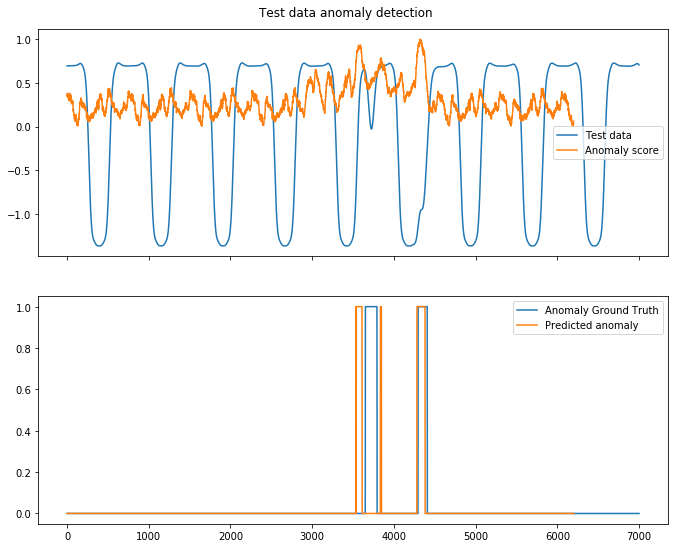

In [ ]:
# Plot
%matplotlib inline

fig, axs = plt.subplots(2,figsize=(10, 8), sharex=True)
fig.suptitle('Test data anomaly detection')
fig.tight_layout(pad=3.0)          
axs[0].plot(test_data.values,label="Test data")
axs[0].plot(anomaly_scores_test, label="Anomaly score")
axs[0].legend()
axs[1].plot(labels.values, label="Anomaly Ground Truth")
axs[1].plot(binary_predict, label="Predicted anomaly")
axs[1].legend()

## Performance of the model

### Custom Confusion Matrix definition
We use a custom function to generate the confusion matrix: we accept predicted anomalies if in the neighboorhoud of the window_size there is a labeled anomaly:

In [ ]:
def confusion_matrix_dataset( true, binary_predict):
    binary_predict = binary_predict.copy()
    tp = 0
    fn = 0
    fp = 0
    n_anomaly = 0
    # measure true positive and false negative
    # for every true anomaly : if detected add 1 true positive, if not detected add 1 false negative
    consecutive = np.split(np.where(true)[0], np.where(np.diff(np.where(true)[0]) > 1)[0] + 1)
    for anom in consecutive:
        if len(anom) < 0:
            break
        n_anomaly += 1
        detected = False
        mini = anom[0]
        maxi = anom[-1]
        for i in range(mini, maxi):
            if binary_predict[i] == 1:
                tp += 1
                detected = True
                binary_predict[mini:maxi] = 0
                break
        if not detected:
            fn += 1
    # measure false positive
    # iterate on binary predict while not all detections have been counted
    # for every false anomaly detected add 1 false positive
    for i in range(len(binary_predict)):
        if binary_predict[i] == 1:
            fp += 1
            # in order to avoid counting the same detection multiple times, we set the next windows to zero
            binary_predict[i: i + window_size] = 0

    # count number of normal windows
    n_normal = 0
    consecutive = np.split(np.where(1 - true)[0], np.where(np.diff(np.where(1 - true)[0]) > 1)[0] + 1)
    for norm in consecutive:
        n_normal += np.ceil(len(norm) / window_size)
    # true negative
    tn = n_normal - fp
    tpr = tp / n_anomaly
    fnr = fn / n_anomaly
    fpr = fp / n_normal
    tnr = tn / n_normal
    return tpr, fnr, fpr, tnr

In [ ]:
import sklearn
# roc curve and auc
tp, fn, fp, tn = confusion_matrix_dataset(labels, binary_predict)
print(pd.DataFrame([[tp, fn], [fp,tn]],columns=["Detected an anomaly", "Detected normal"], index=["Was an anomaly","Was normal"]))

                Detected an anomaly  Detected normal
Was an anomaly                  0.5              0.5
Was normal                      0.1              0.9
